#+TITLE: AutoAugment
#+CATEGORIES: regularization optimization
#+TAGS: augmentation
#+DESCRIPTION: Learning optimal transformation pipelines for data augmentation.
#+AUTHORS: Ekin D. Cubuk, Barret Zoph, Dandelion Mane, Vijay Vasudevan, Quoc V. Le
#+SOURCE: https://arxiv.org/abs/1805.09501
#+DATE: 2024-03-24

# AutoAugment

Data augmentation is a popular technique used to improve generalization performance by creating additional training samples through the augmentation of existing training samples with various strategies like rotation, scaling, flipping, cropping, and brightness or color adjustments. It's a reliable way to increase the size of small datasets and to encourage robust knowledge representations. AutoAugment was introduced to automatically search for optimal data augmentation policies which alleviates the need to manually design data augmentations. They do this by exploring a search space of policies comprised of multiple sub-policies which are randomly selected and applied to each image in a mini-batch. The probability and magnitude of the sub-policies are optimized according to their yielded validation accuracy.

## Key Ideas

- **Search Space:** The search space consists of a collection of sub-policies which contain two image transformation operations (like rotation, translation, inversion, etc.) applied sequentially. Each operation in a sub-policy is associated with specific probabilities and magnitudes that determine how often and to what extent an operation is applied.

- **Policy Optimization:** A reinforcement learning algorithm is employed to navigate the search space where the objective is to discover a data augmentation policy that maximizes the neural network's validation accuracy on a target dataset. A recurrent neural network is used as a controller which predicts an augmentation policy $P$ from the search space. A child network with a fixed architecture is then trained to convergence and the accuracy is used as a reward $R$ for a policy gradient method to update the controller parameters $\theta$ over time according to some learning rate $\alpha$.

$$
\theta \leftarrow \theta + \alpha \nabla_{\theta} \mathbb{E}[R(P, \theta)]
$$

## Results

AutoAugment significantly improved accuracies on the benchmark CIFAR-10, CIFAR-100, SVHN, and ImageNet datasets over established data augmentation strategies, and the learned augmentation policies transferred well across different datasets and tasks without further adaptation. Below is an example for the learned imagenet policy in PyTorch.

In [1]:
autoaugment_imagenet = [
    (("Posterize", 0.4, 8), ("Rotate", 0.6, 9)),
    (("Solarize", 0.6, 5), ("AutoContrast", 0.6, None)),
    (("Equalize", 0.8, None), ("Equalize", 0.6, None)),
    (("Posterize", 0.6, 7), ("Posterize", 0.6, 6)),
    (("Equalize", 0.4, None), ("Solarize", 0.2, 4)),
    (("Equalize", 0.4, None), ("Rotate", 0.8, 8)),
    (("Solarize", 0.6, 3), ("Equalize", 0.6, None)),
    (("Posterize", 0.8, 5), ("Equalize", 1.0, None)),
    (("Rotate", 0.2, 3), ("Solarize", 0.6, 8)),
    (("Equalize", 0.6, None), ("Posterize", 0.4, 6)),
    (("Rotate", 0.8, 8), ("Color", 0.4, 0)),
    (("Rotate", 0.4, 9), ("Equalize", 0.6, None)),
    (("Equalize", 0.0, None), ("Equalize", 0.8, None)),
    (("Invert", 0.6, None), ("Equalize", 1.0, None)),
    (("Color", 0.6, 4), ("Contrast", 1.0, 8)),
    (("Rotate", 0.8, 8), ("Color", 1.0, 2)),
    (("Color", 0.8, 8), ("Solarize", 0.8, 7)),
    (("Sharpness", 0.4, 7), ("Invert", 0.6, None)),
    (("ShearX", 0.6, 5), ("Equalize", 1.0, None)),
    (("Color", 0.4, 0), ("Equalize", 0.6, None)),
    (("Equalize", 0.4, None), ("Solarize", 0.2, 4)),
    (("Solarize", 0.6, 5), ("AutoContrast", 0.6, None)),
    (("Invert", 0.6, None), ("Equalize", 1.0, None)),
    (("Color", 0.6, 4), ("Contrast", 1.0, 8)),
    (("Equalize", 0.8, None), ("Equalize", 0.6, None)),
]

Files already downloaded and verified


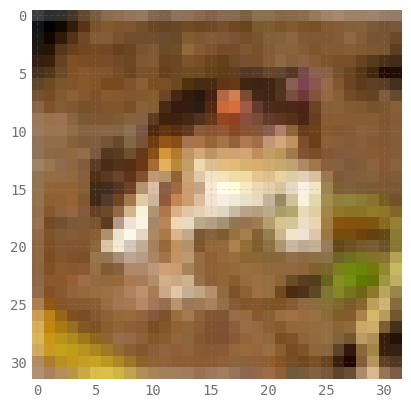

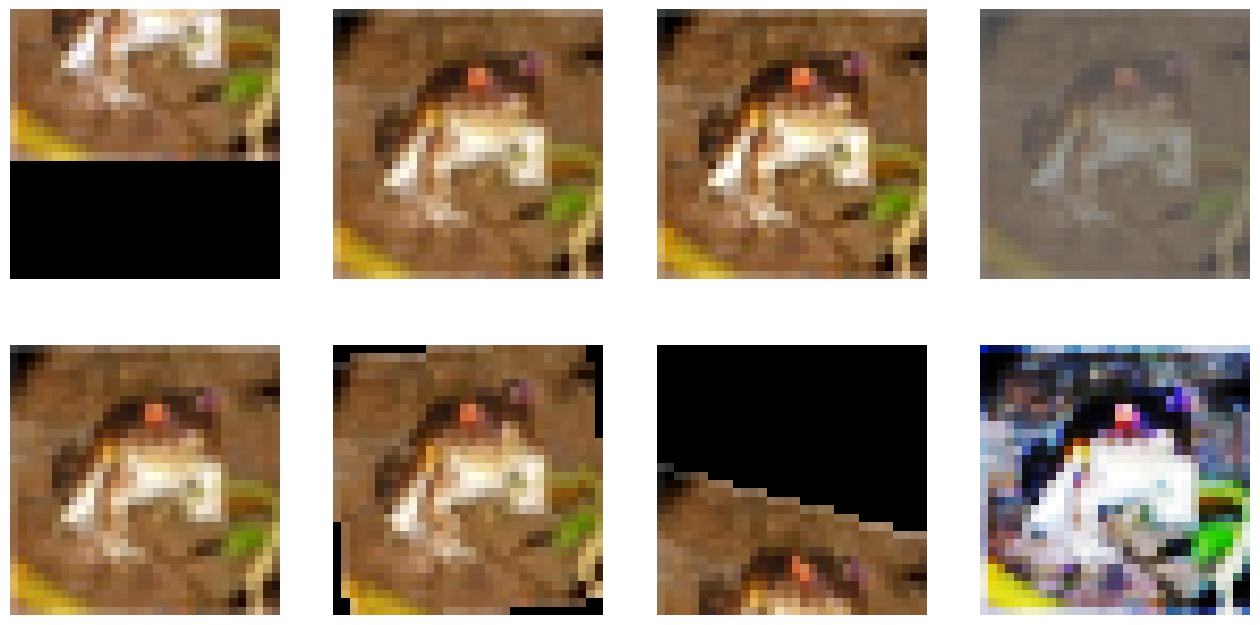

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

plt.style.use('./deadneuron.mplstyle')

dataset = torchvision.datasets.CIFAR10("../data", train=True, download=True)

plt.imshow(dataset[0][0])

def plot_samples(img, transforms, rows=2, cols=4):
    imgs = [transforms(img) for _ in range(rows*cols)]
    
    fig, axs = plt.subplots(rows, cols, figsize=(cols*4,rows*4))
    
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[(cols*i)+j])
            axs[i,j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    

transforms = torchvision.transforms.Compose(
    [torchvision.transforms.RandomCrop(32, padding=4),
     torchvision.transforms.RandomHorizontalFlip()])

img = dataset[0][0]

policy = torchvision.transforms.AutoAugmentPolicy.CIFAR10
transforms = torchvision.transforms.AutoAugment(policy)

plot_samples(img, transforms, 2, 4)